In [1]:
import numpy as np
import matplotlib.pyplot as plt
from code.util import Util
from pymongo import MongoClient
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import NMF
from mlxtend.classifier import EnsembleClassifier
%matplotlib inline

###0: Helper Methods for presentations

In [2]:
#Charting helper method
def MakeChart(fig,ax,title,ylabel,labels,times,scores):
    #Pyplotting
    ax.plot(times,scores,'ro')
    ax.set_xlabel('Seconds')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    #Annotate labels
    for label, x, y in zip(labels, times, scores):
        plt.annotate(
            label, 
            xy = (x, y), xytext = (60, -20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    #show it all
    fig.show()

In [3]:
#Given a classifier, n_top_words, pos and neg vocabulary, return accuracy &
#ROC_AUC scores and times to run
def GetTimeScore(clf,n_top_words,pos,neg):
    #define variables
    times, times1, scores, scores1 = [],[], [],[]
    util = Util()

    #loop through the number of words in n_top_words
    for j in xrange(len(n_top_words)):  
        #build a vectorizer using the NMF sets of words
        nmf_vectorizer = TfidfVectorizer(decode_error='replace',strip_accents='unicode',\
                                    vocabulary = list(set(pos[j]+neg[j])), lowercase=True)
        nmf_review_tfidf = nmf_vectorizer.fit_transform(review_list)        
        #create a copy of the nmf_review_tfidf matrix to apply sentiment weights
        nmf_review_sf = nmf_review_tfidf.copy()

        #for every review
        for i, review_s in enumerate(nmf_review_tfidf):
            #for every index (word) in the review
            for idx in nmf_review_tfidf[i].indices:
                #apply sentiment weighting. if the word is in both lists then
                #the weight value is reduced to 0
                if nmf_vectorizer.vocabulary[idx] in neg and nmf_vectorizer.vocabulary[idx] in pos:
                    nmf_review_sf[i, idx] = 0
                elif nmf_vectorizer.vocabulary[idx] in neg:
                    nmf_review_sf[i, idx] = nmf_review_tfidf[i, idx]*-1
                elif nmf_vectorizer.vocabulary[idx] in pos:
                    nmf_review_sf[i, idx] = nmf_review_tfidf[i, idx]
        # grab the scores and times
        b, a = util.TimevScore([clf],nmf_review_sf,opinion_array,5,\
                           'accuracy')
        d, c = util.TimevScore([clf],nmf_review_sf,opinion_array,5,\
                       'roc_auc')
        #lists for plotting
        scores.extend(a)
        times.extend(b)
        scores1.extend(c)
        times1.extend(d)
    return times,scores,times1,scores1

###1: Create TFIDF matrix with sentiment lexicon weighting (neg=-1, pos=1)

In [5]:
#lists for days
review_list, opinion_list, sentiword_list, sentiment_list,\
            pos, neg = [],[],[],[],[],[]
    
#PyMongo variables for reviews
client = MongoClient()
db = client['reviews']
collection = db['movies']
reviews = collection.find()

#PyMongo variables for sentiment
db1 = client['sentiment']
collection1 = db1['bingliu']
sentiments = collection1.find()

#build review and label lists
for review in reviews:
    opinion_list.append(review['Opinion'])
    review_list.append(review['Review'])

#label array
opinion_array = np.array(opinion_list)    

#build sentiment word, sentiment polarity, pos word, neg word lists
for sentiment in sentiments:
    sentiword_list.append(sentiment['Word'])
    sentiment_list.append(sentiment['Sentiment'])
    if sentiment['Sentiment'] == 1:
        pos.append(sentiment['Word'])
    elif sentiment['Sentiment'] == -1:
        neg.append(sentiment['Word'])

#vectorize words using sentiment words as vocab, lowercase, replace decode
#errors and strip accents using unicode
vectorizer = TfidfVectorizer(decode_error='replace',strip_accents='unicode',\
                            vocabulary = sentiword_list, lowercase=True)
review_tfidf = vectorizer.fit_transform(review_list)
#Copy the review tfidf matrix to apply sentiment weights
review_sf = review_tfidf.copy()

#for every review
for i, review_s in enumerate(review_tfidf):
    #for every index (word) in the review
    for idx in review_tfidf[i].indices:
        #apply sentiment weighting
        if vectorizer.vocabulary[idx] in neg:
            review_sf[i, idx] = review_tfidf[i, idx]*-1
        elif vectorizer.vocabulary[idx] in pos:
            review_sf[i, idx] = review_tfidf[i, idx]

###2: Model using the above TFIDF matrix

In [6]:
#who doesn't love utility classes            
util = Util()

#some classifiers that have been tuned
clf1 = LogisticRegression('l2')
clf2 = BernoulliNB(alpha=0,fit_prior=False)

#ensemble classifier
eclf = EnsembleClassifier(clfs=[clf1, clf2], weights=[1,1])

###3: View the model scores (Non NMF)

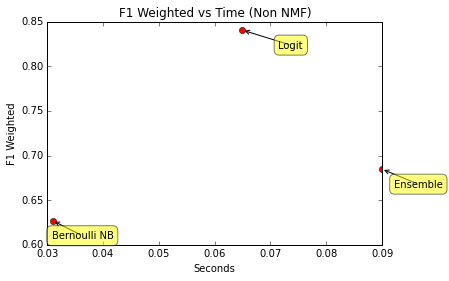

In [8]:
#get lists of scores and times
times1,scores1 = util.TimevScore([clf1,clf2,eclf],review_sf,opinion_array,5,\
                       'f1_weighted')
#plotting
f1, axarr1 = plt.subplots(1)
#Plotting method
MakeChart(f1,axarr1,'F1 Weighted vs Time (Non NMF)','F1 Weighted',
          ['Logit','Bernoulli NB','Ensemble'],times1,scores1)

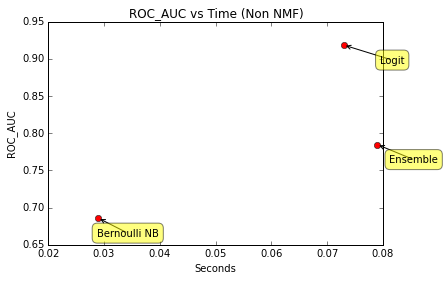

In [10]:
# get lists of scores and times
times2,scores2 = util.TimevScore([clf1,clf2,eclf],review_sf,opinion_array,5,\
                       'roc_auc')
#plotting
f2, axarr2 = plt.subplots(1)
#Plotting method
MakeChart(f2,axarr2,'ROC_AUC vs Time (Non NMF)','ROC_AUC',
          ['Logit','Bernoulli NB','Ensemble'],times2,scores2)

###4: Create NMF models with various n top words for the 2 sentiment categories (pos, neg)

In [17]:
#NMF Hyperparameters
n_topics = 2
n_top_words = [10,20,50,100,1000,2000,5000]

#Lists of data
review_list, opinion_list, sentiword_list, sentiment_list,\
            pos, neg = [],[],[],[],[],[]
    
#PyMongo variables
client = MongoClient()
db = client['reviews']
collection = db['movies']
reviews = collection.find()

#PyMongo variables for sentiment
db1 = client['sentiment']
collection1 = db1['bingliu']
sentiments = collection1.find()

#build review and label lists
for review in reviews:
    opinion_list.append(review['Opinion'])
    review_list.append(review['Review'])

#label array
opinion_array = np.array(opinion_list)    

#build sentiment word, sentiment polarity, pos word, neg word
for sentiment in sentiments:
    sentiword_list.append(sentiment['Word'])

#vectorize words using sentiment words as vocab, lowercase, replace decode
#errors and strip accents using unicode
vectorizer = TfidfVectorizer(decode_error='replace',strip_accents='unicode',\
                            lowercase=True)
review_tfidf = vectorizer.fit_transform(review_list)

#NMF model fit using review_tfidf
nmf = NMF(n_components=n_topics,).fit(review_tfidf)
#Feature names
feature_names = vectorizer.get_feature_names()

#loop through the topics in the nmf
for topic_idx, topic in enumerate(nmf.components_):
    #loop through the number of words in n_top_words
    for n_top_word in n_top_words:
        #build pos and neg word lists
        if topic_idx == 0:
            neg.append([feature_names[i]
                        for i in topic.argsort()[:-n_top_word - 1:-1]])
        elif topic_idx == 1:
            pos.append([feature_names[i]
                        for i in topic.argsort()[:-n_top_word - 1:-1]])

###5: Run models using the output of NMF as vocabulary for the vectorizer. The sentiment weights are applied to a tf_idf matrix that only takes into account words generated by the NMF trained on all reviews

In [18]:
#Logit
clf1 = LogisticRegression('l2')
GetTimeScore(clf1,n_top_words,pos,neg)
times3, scores3, times4, scores4 = GetTimeScore(clf1,n_top_words,pos,neg)

###6: View the model scores (NMF -> Logit)

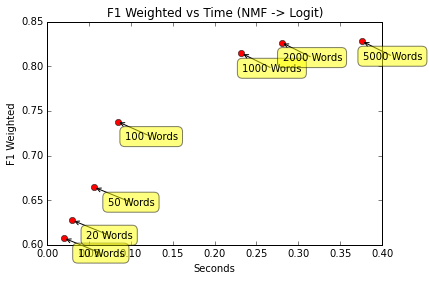

In [20]:
#matplotlib
f3, axarr3 = plt.subplots(1)
#Build a chart
MakeChart(f3,axarr3,'F1 Weighted vs Time (NMF -> Logit)','F1 Weighted',
          ['10 Words','20 Words','50 Words','100 Words','1000 Words',
           '2000 Words','5000 Words']
          ,times3,scores3)

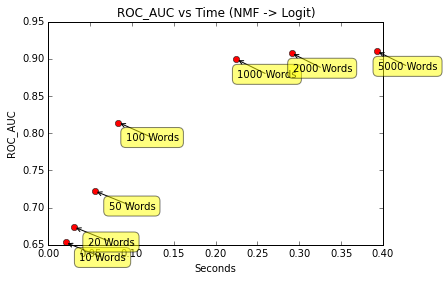

In [22]:
f4, axarr4 = plt.subplots(1)
MakeChart(f4,axarr4,'ROC_AUC vs Time (NMF -> Logit)','ROC_AUC',
['10 Words','20 Words','50 Words','100 Words','1000 Words',
           '2000 Words','5000 Words']
          ,times4,scores4)

In [23]:
#BernoulliNB
clf1 = BernoulliNB(fit_prior=False)
GetTimeScore(clf1,n_top_words,pos,neg)
times5, scores5, times6, scores6 = GetTimeScore(clf1,n_top_words,pos,neg)

###7: View the model scores (NMF -> Bernoulli NB)

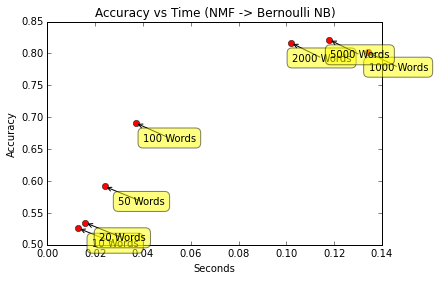

In [25]:
#matplotlib
f5, axarr5 = plt.subplots(1)
#Build a chart
MakeChart(f5,axarr5,'Accuracy vs Time (NMF -> Bernoulli NB)','Accuracy',
          ['10 Words','20 Words','50 Words','100 Words','1000 Words',
           '2000 Words','5000 Words'],times5,scores5)

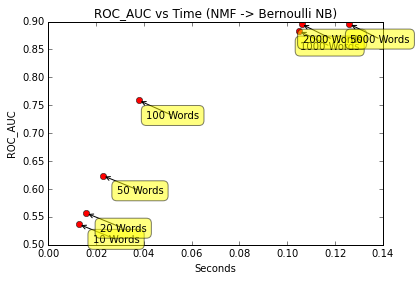

In [26]:
f6, axarr6 = plt.subplots(1)
MakeChart(f6,axarr6,'ROC_AUC vs Time (NMF -> Bernoulli NB)','ROC_AUC',
          ['10 Words','20 Words','50 Words','100 Words','1000 Words',
           '2000 Words','5000 Words'],times6,scores6)

In [27]:
#Ensemble
clf1 = LogisticRegression('l2')
clf2 = BernoulliNB(fit_prior=False)
eclf = EnsembleClassifier(clfs=[clf1, clf2], weights=[1,1])

GetTimeScore(eclf,n_top_words,pos,neg)
times7, scores7, times8, scores8 = GetTimeScore(clf1,n_top_words,pos,neg)

###8: View the model scores (NMF -> Ensemble)

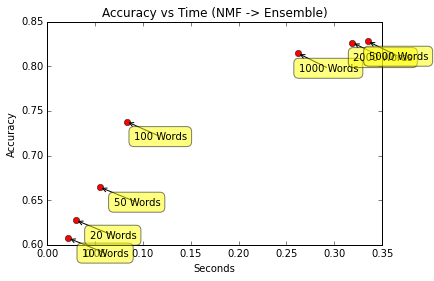

In [28]:
#matplotlib
f7, axarr7 = plt.subplots(1)
#Build a chart
MakeChart(f7,axarr7,'Accuracy vs Time (NMF -> Ensemble)','Accuracy',
          ['10 Words','20 Words','50 Words','100 Words','1000 Words',
           '2000 Words','5000 Words'],times7,scores7)

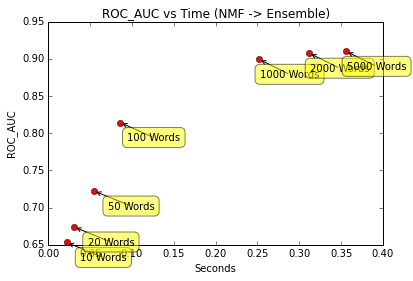

In [29]:
#matplotlib
f8, axarr8 = plt.subplots(1)
#Build a chart
MakeChart(f8,axarr8,'ROC_AUC vs Time (NMF -> Ensemble)','ROC_AUC',
          ['10 Words','20 Words','50 Words','100 Words','1000 Words',
           '2000 Words','5000 Words'],times8,scores8)